<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Random Forest Models with All Features</h4>
    <h5 style="font-weight: bold; font-size: 24px;">Test Set using Expanding Window</h5>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

[Inspect Expanding Training Window](#Inspect-Training-Windows)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**
  
**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

# Setup

[Return to top](#Models)

In [16]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

# Data

[Return to top](#Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [17]:
# load, filter (by time) and scale data
pts_all_features, pm_all_features, res_all_features, test_set_obs = utl.load_and_scale_data(
    input_data='../../data/processed/nba_team_matchups_all_rolling_stats_merged_2021_2024_r10.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'],
    training_season='2021-22',
    feature_prefixes=['ROLL_', 'ROLLDIFF_'],
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 691 games
Total number of games across sampled seasons: 3058 games


In [18]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181
season_24_ngames = 691

In [4]:
pts_all_features.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,...,ROLL_HOME_CFG_PCT,ROLL_HOME_UFGM,ROLL_HOME_UFGA,ROLL_HOME_UFG_PCT,ROLL_HOME_DFGM,ROLL_HOME_DFGA,ROLL_HOME_DFG_PCT,ROLL_AWAY_DIST,ROLL_AWAY_ORBC,ROLL_AWAY_DRBC,ROLL_AWAY_RBC,ROLL_AWAY_TCHS,ROLL_AWAY_SAST,ROLL_AWAY_FTAST,ROLL_AWAY_PASS,ROLL_AWAY_CFGM,ROLL_AWAY_CFGA,ROLL_AWAY_CFG_PCT,ROLL_AWAY_UFGM,ROLL_AWAY_UFGA,ROLL_AWAY_UFG_PCT,ROLL_AWAY_DFGM,ROLL_AWAY_DFGA,ROLL_AWAY_DFG_PCT,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.745,0.522,0.248,0.784,0.769,0.552,0.731,0.955,0.943,0.535,0.571,0.238,0.478,0.667,1.000,1.000,0.600,0.643,0.577,0.586,0.187,0.761,0.526,0.176,1.000,...,0.526,0.696,0.667,0.761,1.000,1.00,0.352,0.553,0.613,0.000,0.180,0.401,0.250,0.816,0.457,0.667,0.731,0.584,0.409,0.130,0.841,0.611,0.423,1.000,185
2021-10-23,0.000,0.000,0.624,0.000,0.077,0.372,0.000,0.553,0.574,0.438,1.000,0.333,0.826,0.000,0.385,0.238,0.657,0.554,0.096,0.017,0.350,0.000,0.421,0.588,0.364,...,0.142,0.000,0.333,0.000,1.000,0.60,0.762,0.491,0.387,0.419,0.353,0.463,0.125,0.204,0.438,0.000,0.462,0.000,0.364,0.413,0.286,0.167,0.269,0.440,198
2021-10-23,0.691,0.652,0.474,0.788,0.462,0.417,0.466,0.704,0.574,0.720,0.286,0.571,0.609,0.611,0.000,0.333,0.257,0.643,0.635,0.586,0.160,0.787,0.263,0.265,0.396,...,0.619,0.391,0.267,0.676,0.438,0.16,0.720,0.454,0.032,0.710,0.309,0.567,0.375,0.408,0.604,0.267,0.231,0.601,0.682,0.391,0.855,0.056,0.423,0.000,239
2021-10-23,0.727,0.826,0.662,0.860,0.538,0.193,0.772,0.352,0.410,0.315,0.571,0.095,0.348,1.000,0.231,0.143,0.029,0.643,0.250,0.069,0.106,0.244,0.368,0.559,0.317,...,0.768,0.739,0.800,0.712,0.500,0.52,0.291,0.620,0.452,0.387,0.353,0.312,0.375,0.204,0.281,0.400,0.269,0.760,0.136,0.326,0.000,0.500,0.346,0.964,232
2021-10-24,0.745,0.783,0.549,0.883,0.846,0.552,0.820,0.302,0.246,0.560,0.357,0.762,0.826,0.833,0.538,0.810,0.543,0.286,1.000,0.897,1.000,0.391,0.842,1.000,0.559,...,0.583,0.565,0.367,0.850,0.375,0.60,0.075,1.000,0.903,0.387,0.633,1.000,0.875,0.612,0.906,0.200,0.346,0.367,1.000,1.000,0.500,0.778,0.731,0.726,204


# Inspect Expanding Training Window

[Return to top](#Models)

In [5]:
# expanding window configuration
initial_train_size = 10  # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation
gap_size=0               # should there be a gap between train and test sets?
expansion_limit=None     # the limit on the test set observations

counter = 0
max_splits_to_show = 15

# show first few splits
for train_indices, test_indices in utl.expanding_window_ts_split(pts_all_features, initial_train_size, 
                                                                 test_size=test_size, gap_size=gap_size,
                                                                 expansion_limit=expansion_limit):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9

<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Models)

In [6]:
# load the best hyperparameters dictionary back from the file
with open('../../hyperparameters/RF_pts_best_params_all_features.json', 'r') as json_file:
    best_params = json.load(json_file)

# configuration for total points with expanding window
model = RandomForestRegressor(**best_params)  # model class
target_col = 'TOTAL_PTS'    # target column name
df = pts_all_features          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1       # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 7240.71 seconds


In [7]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 18.63
- Null RMSE: 20.28


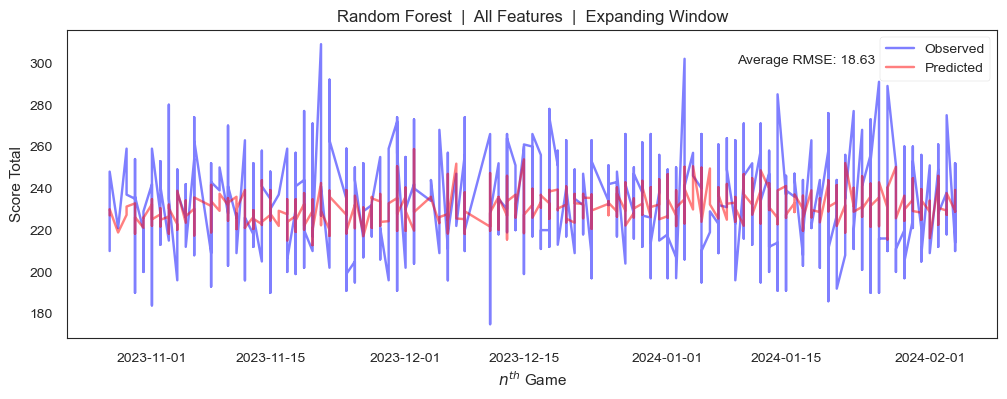

In [8]:
utl.plot_model_performance(
    title='Random Forest  |  All Features  |  Expanding Window',
    y_label='Score Total',
    metric=metrics['average_rmse'], 
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Models)

In [ ]:
# load the best hyperparameters dictionary back from the file
with open('../../hyperparameters/RF_pm_best_params_all_features.json', 'r') as json_file:
    best_params = json.load(json_file)

# configuration for points difference with expanding window
model = RandomForestRegressor(**best_params)  # model class
target_col = 'PLUS_MINUS'    # target column name
df = pm_all_features          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1        # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
pm_rf_model, model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    fitted_model=True
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

In [ ]:
# write out model
joblib.dump(pm_rf_model, '../../data/fitted_models/pm_rf.joblib')

In [10]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 14.20
- Null RMSE: 15.32


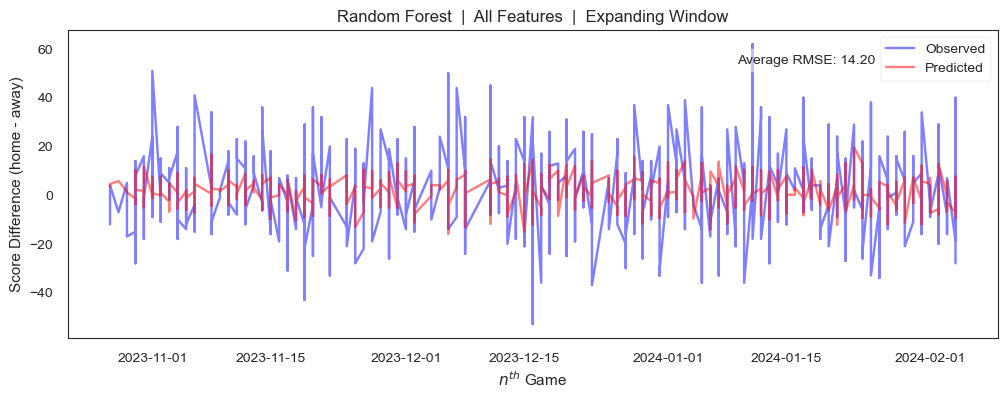

In [11]:
utl.plot_model_performance(
    title='Random Forest  |  All Features  |  Expanding Window',
    y_label='Score Difference (home - away)',
    metric=metrics['average_rmse'], 
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Models)

In [12]:
# load the best hyperparameters dictionary back from the file
with open('../../hyperparameters/RF_res_best_params_all_features.json', 'r') as json_file:
    best_params = json.load(json_file)

# configuration for game winner with expanding window
model = RandomForestClassifier(**best_params)  # model class
target_col = 'GAME_RESULT'    # target column name
df = res_all_features          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1      # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    ensure_diversity=True # ensure class diversity in training
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 268.49 seconds


In [13]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Baseline Accuracy: 0.56
- Average Accuracy: 0.56
- Overall AUC: 0.46
- Average F1 Score: 0.72


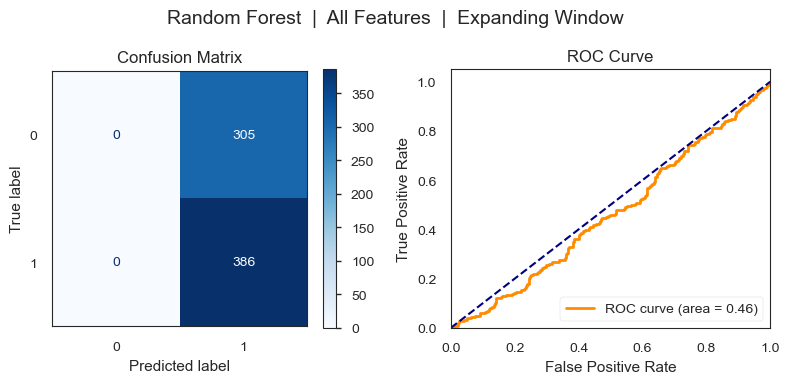

In [14]:
utl.plot_classification_performance(
    y_true=y_true, 
    model_outputs=model_outputs,
    pred_labels=metrics['pred_labels'],
    overall_title='Random Forest  |  All Features  |  Expanding Window'
)

In [15]:
# write out all model predictions and meta-data
test_set_obs.rename(columns={
    'TOTAL_PTS': 'TOTAL_PTS_PREDS',
    'PLUS_MINUS': 'PLUS_MINUS_PREDS',
    'GAME_RESULT': 'GAME_RESULT_PREDS'
}, inplace=True)
columns_to_round = ['TOTAL_PTS_PREDS', 'PLUS_MINUS_PREDS', 'GAME_RESULT_PREDS']
test_set_obs[columns_to_round] = test_set_obs[columns_to_round].round(4)
test_set_obs.to_csv('../../data/model_predictions/RF_preds_all_features.csv', index=False)